##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">LABORATORIUM 4</style></h1>
    <h1 style = "font-size:24px">z Przetwarzania multimediów w systemach decyzyjnych</style></h1>
    <h1 style = "font-size:24px">Przegląd algorytmów uczących się metryk dystansu dla
danych akustycznych</style></h1>
    <h1 style = "font-size:24px">Przemysław Rośleń</style></h1>
    <h3 style = "font-size:21px">analiza widmowa przykładów ze zbioru GTZAN</h3>
    <h3 style =
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# Pobranie danych z Kaggle


W ćwiczeniu zilustrujemy przetwarzanie sygnałów akustycznych za pomocą przetwarzania nagrań muzycznych. Jednym ze zbiorów danych często wybieranych do nauki przetwarzania sygnałów muzycznych jest zbiór GTZAN. Niestety, w bibliotece Tensorflow Datasets, która zwykle jest wygodnym wyborem do pozyskiwania danych, pobieranie tego zbioru danych następuje z bardzo wolnego serwera, dlatego w tym ćwiczeniu zalecane jest posłużenie się danymi pobranymi z serwisu Kaggle:<br/>
https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification
<br/><br/>
Pobrane archiwum (archive.zip) należy następnie załadować na własny dysk Google Drive (do głównego folderu), a ten podłączyć do środowiska Google Colab. W menu plików maszyny wirtualnej pojawi się możliwość skopiowania pliku do maszyny wirtualnej, co należy uczynić wykonując komórkę poniżej:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Następnie można wykonać poniższą komórkę w celu rozpakowania archiwum. Zakłada ona, że archiwum jest w głównym folderze dysku, skąd jest ono kopiowane do pamięci sesji i rozpakowywane.

In [ ]:
!cp drive/MyDrive/archive.zip archive.zip
!unzip archive.zip

Archive:  archive.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wav  
  inflating: Data/genres_orig

Import bibliotek koniecznych do dalszego wykonania ćwiczenia:

In [ ]:
import numpy as np
import os
from   scipy.io.wavfile import read
import matplotlib.pyplot as plt
import copy as cp
from scipy.fftpack import fft
from librosa.feature import mfcc
from tqdm import tqdm

# Analiza widmowa danych ze zbioru GTZAN

Po pozyskaniu danych możliwe staje się przeanalizowanie danych. Najpierw wykorzystamy do tego analizę za pomocą algorytmu FFT, a dokładniej - spektrogramów. Wpierw zdefiniujmy kilka funkcji pomocnicznych:

In [ ]:
# Funkcja wycinająca wybrany fragment sygnału o zadanej szybkości próbkowania fs
# (miejsca cięć podajemy w sekundach)
def obtain_signal_slice(insignal, fs, cut_start, cut_stop):
    cut_start_idx = int(fs*cut_start)
    cut_stop_idx  = int(fs*cut_stop)

    if cut_stop_idx>len(insignal):
        raise RuntimeError("błąd - czas zakończenia cięcia jest późniejszy niż długość nagrania")

    return insignal[cut_start_idx:cut_stop_idx]

# Pomocnicza funkcja do podziału danych na ramki:
#    - możliwe jest zadanie długości ramki,
#    - oraz okreslenie, w jakim ułamku ramki te powinny na siebie nachodzić
#    (tzw. overlap factor).
def split_to_frames(insignal, frame_length, overlap_factor):
    shift_factor        = frame_length*(1-overlap_factor)
    target_frames_count = (len(insignal)-frame_length)/shift_factor
    shift_factor        = int(shift_factor)
    target_frames_count = int(target_frames_count)
    output_data         = np.zeros((frame_length, target_frames_count))

    for i in range(target_frames_count):
        frame_start      = i*shift_factor
        frame_end        = frame_start + frame_length
        output_data[:,i] = insignal[frame_start:frame_end]

    return output_data

# Funkcja licząca spektrogram na podstawie danych audio podzielonych na ramki
def frames_to_spectrogram(frames_mtx, fft_window):
    output_data = cp.copy(frames_mtx)
    for i in range(output_data.shape[1]):
        output_data[:,i] = np.abs(fft(output_data[:,i]*fft_window))

    output_data = output_data[0:output_data.shape[0]//2,:]
    return output_data

# Funkcja która łącznie dzieli sygnał na ramki i liczy spektrogram.
def signal_to_spectrogram(ex, frame_length, overlap_factor, fft_window):
    split_ex    = split_to_frames(ex, frame_length, overlap_factor)
    spectrogram = frames_to_spectrogram(split_ex, fft_window)
    return spectrogram

Następnie możemy przystąpić do analizowania wybranych plików ze zbioru GTZAN:

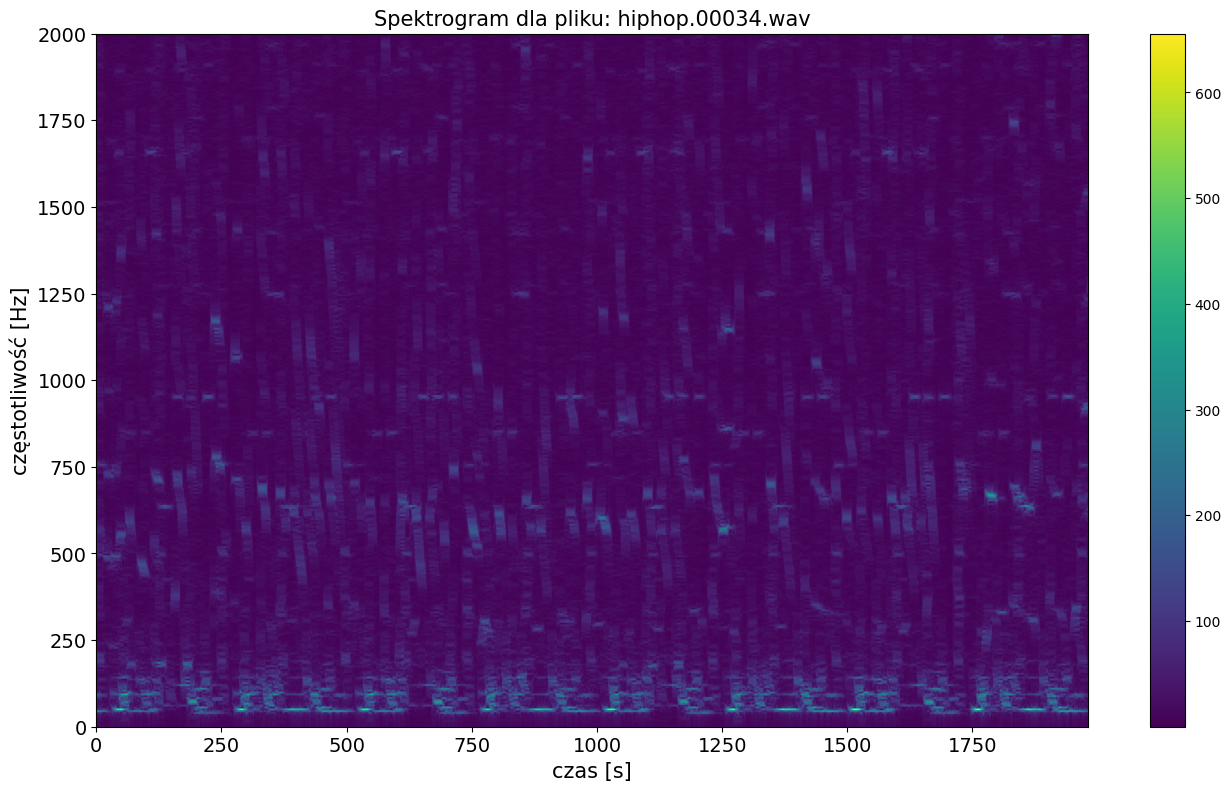

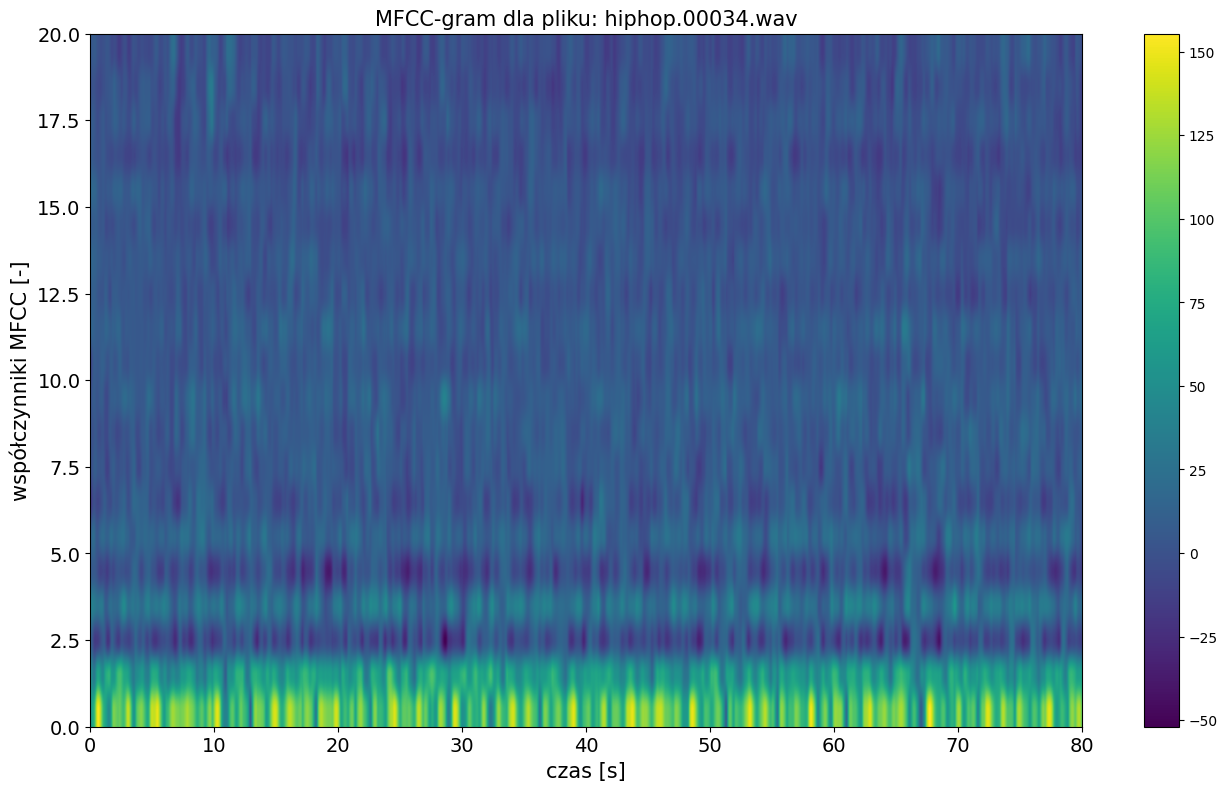

In [ ]:
# ------------------------------------------------------------------
# Ścieżki do analizowanego pliku i do zbioru danych GTZAN:
gtzan_dataset_inpath = "Data/genres_original"
chosen_fpath         = "hiphop/hiphop.00034.wav"

# ------------------------------------------------------------------
# Nastawy przetwarzania pliku za pomocą spektrogramów
frame_length   = 1024 * 4 # szerokość okna analizy (w próbkach)
overlap_factor = 0.99 # współczynnik nachodzenia się na siebie
                      # ramek danych (okien analizy)
cut_start      = 0    # początek wycinka nagrania pozyskiwanego do analizy [s]
cut_stop       = 20   # koniec wycinka nagrania pozyskiwanego do analizy [s]
fft_window     = np.ones(frame_length) # funkcja okna
# Inne okna można wygenerować funkcjami z:
# https://numpy.org/doc/stable/reference/routines.window.html

# Nastawy przetwarzania pliku za pomocą MFCC-gramów:
n_mfcc         = 20   # liczba współczynników MFCC w ramce
n_fft          = 1024 * 4 # długość FFT wykorzystana do obliczenia
                      # współczynników MFCC

# ------------------------------------------------------------------
# Przetwarzanie danych:

# Przygotowanie ścieżki do czytanego pliku
joint_path = os.path.join(gtzan_dataset_inpath,chosen_fpath)

# Odczyt danych
fs, audio_data  = read(joint_path)

# Konwersja i normalizacja typu odczytanych danych
audio_data = audio_data.astype(float)
audio_data = audio_data/np.max(np.abs(audio_data))

# pobranie wycinka danych akustycznych
audio_slice    = obtain_signal_slice(audio_data, fs, cut_start, cut_stop)

# obliczenie spektrogramu
spectrogram    = signal_to_spectrogram(audio_slice, frame_length, overlap_factor, fft_window)

# obliczenie MFCC-gramu
mfccgram       = mfcc(y=audio_slice, sr=fs, n_mfcc=n_mfcc, n_fft=n_fft)

# ------------------------------------------------------------------
# Wizualizacja

fontsize = 15

plt.figure(figsize=(16,9))
plt.imshow(spectrogram, aspect='auto', origin="lower", extent=[0,spectrogram.shape[1]*frame_length/fs,0,fs//2])
plt.xlabel("czas [s]", fontsize=fontsize)
plt.ylabel("częstotliwość [Hz]", fontsize=fontsize)
plt.title(f"Spektrogram dla pliku: {os.path.basename(chosen_fpath)}", fontsize=fontsize)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.colorbar()

# Czasami żeby zauważyć najciekawsze szczegóły konieczne będzie zbliżenie na
# dolną część widma. Odkomentować w razie potrzeby:
plt.ylim([0,2000])

plt.figure(figsize=(16,9))
plt.imshow(mfccgram, aspect='auto', origin="lower", extent=[0,mfccgram.shape[1]*n_fft/fs/2,0,n_mfcc])
plt.xlabel("czas [s]", fontsize=fontsize)
plt.ylabel("współczynniki MFCC [-]", fontsize=fontsize)
plt.title(f"MFCC-gram dla pliku: {os.path.basename(chosen_fpath)}", fontsize=fontsize)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.colorbar()

plt.show()